## limpieza y procesamiento de tablas

0. Juntar tablas de proyectos y evaluadores (uno a muchos)
1. Aplicar limpieza y steamming
2. Agrupar textos por evaluador
3. Análisis de longitud de textos por investigador

---




In [2]:
import pandas as pd
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize
import heapq

from joblib import load, dump
nltk.download('wordnet')
nltk.download('punkt')

stemmer = SnowballStemmer('spanish')

pd.options.mode.chained_assignment = None #...
import seaborn as sns


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Descripción del proyecto:

In [30]:
data_topics = load("../data/entrenamiento_convocatorias/datos_entrenamiento_convocatorias_sample_filtro.pkl")
data_topics.rename({"resumen_es":"DESCRIPCION_PROYECTO"}, inplace=True, axis=1)
data_topics.rename({"DESCRIPCION":"DESCRIPCION_PROYECTO"}, inplace=True, axis=1)

data_topics.head(2)

,CVU,IVIGENCIA,FVIGENCIA,NIVEL,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO
0,14841,2018-01-01,2022-12-31 00:00:00,3,254622,I0017,2000,None,None,None,None,None,Uno de los principales problemas de salud que ...
1,14841,2018-01-01,2022-12-31 00:00:00,3,258332,I0017,2000,None,None,None,None,None,En los pasados 15 años nuestro equipo de traba...


In [31]:
data_topics.shape

(40201, 13)

In [32]:
data_topics.columns

Index(['CVU', 'IVIGENCIA', 'FVIGENCIA', 'NIVEL', 'ID_PROYECTO',
       'NUMERO_CONVOCATORIA', 'ANIO', 'PALABRAS_CLAVE', 'SUBDISCIPLINA',
       'DISCIPLINA', 'AREA', 'TITULO', 'DESCRIPCION_PROYECTO'],
      dtype='object')

Funciones para estandarizar y limpiar los datos:

In [33]:
def clean_str_series(s):
    """
    info:
    """
    
    s = s.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8') \
         .str.capitalize().str.strip().str.replace('[^\w\s]','')
    return s

In [34]:
def text_cleaner(df,columns_to_clean,columns_not_na):
    """
    info:
    """
    
    
    # Quitar registros no validos
    df = df.dropna(subset=columns_not_na,axis=0)

    # Formato texto
    for d in columns_to_clean:
        if df[d].dtype == object: 
            df[d] = clean_str_series(df[d])
    
    return df

In [35]:
columns_not_na = ["DESCRIPCION_PROYECTO"]
columns_interes = ["DESCRIPCION_PROYECTO"]

data_topics_clean = text_cleaner(data_topics, columns_to_clean=columns_interes, columns_not_na=columns_not_na)

In [36]:
data_topics_clean.head()

,CVU,IVIGENCIA,FVIGENCIA,NIVEL,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO
0,14841,2018-01-01,2022-12-31 00:00:00,3,254622,I0017,2000,None,None,None,None,None,Uno de los principales problemas de salud que ...
1,14841,2018-01-01,2022-12-31 00:00:00,3,258332,I0017,2000,None,None,None,None,None,En los pasados 15 anos nuestro equipo de traba...
2,14841,2018-01-01,2022-12-31 00:00:00,3,168560,I0017,2000,None,None,None,None,None,Las complicaciones hepaticas asociadas al acum...
3,14841,2018-01-01,2022-12-31 00:00:00,3,243406,I0017,2000,None,None,None,None,None,Antecedentes\r\nla enfermedad de higado graso ...
4,14841,2018-01-01,2022-12-31 00:00:00,3,134346,I0003,2000,None,None,None,None,None,La inflamacion es una caracteristica comun de ...


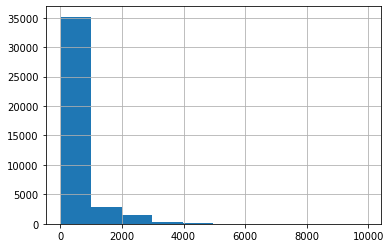

In [37]:
data_topics_clean["DESCRIPCION_PROYECTO"].str.count(" ").hist()

Número total de evaluadores:

### Steamming

In [38]:
min_len = 4

def stemSentence(sentence, min_len=min_len):
    """
    info
    """
    
    token_words = word_tokenize(sentence)
    stem_sentence = []
    
    for word in token_words:
        if len(word) > min_len:
            stem_sentence.append(stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')))
            stem_sentence.append(" ")
    return "".join(stem_sentence)

obtener raices y quitar palabras cortas

In [39]:
%%time 
text_data = data_topics_clean["DESCRIPCION_PROYECTO"]
text_data = text_data.apply(stemSentence)

data_topics_clean["DESCRIPCION_PROYECTO"] = text_data

CPU times: user 7min 48s, sys: 1.94 s, total: 7min 50s
Wall time: 7min 56s


In [40]:
data_topics_clean.head()

,CVU,IVIGENCIA,FVIGENCIA,NIVEL,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO
0,14841,2018-01-01,2022-12-31 00:00:00,3,254622,I0017,2000,None,None,None,None,None,principal problem salud aquej poblacion mexica...
1,14841,2018-01-01,2022-12-31 00:00:00,3,258332,I0017,2000,None,None,None,None,None,pas nuestr equip trabaj realiz diferent estudi...
2,14841,2018-01-01,2022-12-31 00:00:00,3,168560,I0017,2000,None,None,None,None,None,complic hepat asoci acumul gras corporal relac...
3,14841,2018-01-01,2022-12-31 00:00:00,3,243406,I0017,2000,None,None,None,None,None,antecedent enfermed hig gras alcohol entid com...
4,14841,2018-01-01,2022-12-31 00:00:00,3,134346,I0003,2000,None,None,None,None,None,inflamacion caracterist comun much enfermedad ...


In [42]:
dump(data_topics_clean, "../data/datos_training_n_eval_5.pkl")

['../data/datos_training_n_eval_5.pkl']

In [47]:
"--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------c----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------c---------------------------------------------------------------------------------------------------".count("-")

14433